# TDA de Cambios en Precios y Oferta-Demanda de Productos Perecederos
Author: A. Ramirez-Morales (andres.ramirez@tec.mx)


En este notebook se implementa:
1. Generación avanzada de datos con Monte Carlo
2. Análisis TDA completo (homología persistente + Mapper)
3. Detección de cambios estructurales con ventanas deslizantes y Takens embedding
4. Modelos predictivos híbridos (TDA + ML)

### 1. Importación de librerías

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram
from gtda.mapper import (
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph
)
from sklearn.cluster import DBSCAN
from imblearn.over_sampling import SMOTE
import networkx as nx
np.random.seed(42)
plt.style.use('ggplot')

### 1. Generación de datos

Actividades/preguntas:
1. Definir los siguientes conceptos: producto perecedero, evento de mercado, brokers, estrategia de broker, tipos de estrageias de broker, variables climaticas, estacionalidad, calidad de producto, elasticidad cruzada
2. Comentar (describir) las líneas más importantes y escribir documentación adecuada para la clase `DatosAgricolas`
3. En la clase `DatosAgricolas` hay varios parámetros que usted puede ajustar, identifíquelos e interprete ssu efecto en los datos.
4. Describa el outcome que espera de la clase `DatosAgricolas`
5. Discuta cualesquiera otras informaciones en `DataAgricolas` que puedan ser relevantes.

Explicación del código:



In [ ]:
class DatosAgricolas:
    """
    Simulación de datos para productos agrícolas perecederos
    con eventos de mercado, comportamientos de brokers y variables climáticas.
    """
    def __init__(self, params, n_dias=1000, factor=1000,  interesante=True):
        self.n_dias = n_dias
        self.fechas = pd.date_range(start="2023-01-01", periods=n_dias, freq='D')
        self.df = None
        self.eventos = None
        self.interesante = interesante
        # frambuesa data
        self.m_precio_frambuesa = params['precio_frambuesa']/factor
        self.m_precio_frambuesa_var = params['precio_frambuesa_var']/factor
        self.m_volumen_frambuesa = params['volumen_frambuesa']/factor
        self.m_volumen_frambuesa_var = params['volumen_frambuesa_var']/factor
        # aguacate data
        self.m_precio_aguacate = params['precio_aguacate']/factor
        self.m_precio_aguacate_var = params['precio_aguacate_var']/factor
        self.m_volumen_aguacate = params['volumen_aguacate']/factor
        self.m_volumen_aguacate_var = params['volumen_aguacate_var']/factor
        # chile data
        self.m_precio_chile = params['precio_chile']/factor
        self.m_precio_chile_var = params['precio_chile_var']/factor
        self.m_volumen_chile = params['volumen_chile']/factor
        self.m_volumen_chile_var = params['volumen_chile_var']/factor

       
    def generar_base(self):
        """
        Genera datos base para los productos
        """
        # precios base con tendencias estacionales
        tiempo = np.linspace(0, 10, self.n_dias)
        estacionalidad = np.sin(2 * np.pi * tiempo / 365) * 0.2

        # variables climáticas, que cambiarán la calidad de la fruta
        temperatura = 25 + 10 * np.sin(2 * np.pi * tiempo / 365) + np.random.normal(0, 3)
        humedad = 60 + 20 * np.sin(2 * np.pi * tiempo / 365 + np.pi/2) + np.random.normal(0, 5)
        
        # frambuesa - producto altamente perecedero
        # aqui hice el cambio para que no haya ruido y solo un cambio estacional simulado con una funcion sin(x)
        precio_frambuesa  = self.m_precio_frambuesa * np.sin(tiempo*2*np.pi) # np.exp(np.random.normal(self.m_precio_frambuesa + estacionalidad, self.m_precio_frambuesa_var, size=self.n_dias))
        volumen_frambuesa = np.random.normal(self.m_volumen_frambuesa, self.m_volumen_frambuesa_var, size=self.n_dias) + np.random.normal(0, 50) * estacionalidad
        calidad_frambuesa = np.clip(0.9 - 0.005*(temperatura-25)**2 - 0.002*(humedad-70)**2 + np.random.normal(0, 0.05), 0.5, 1.0)

        # aguacate - menos perecedero
        precio_aguacate = np.exp(np.random.normal(self.m_precio_aguacate + estacionalidad*0.5, self.m_precio_aguacate_var, size=self.n_dias))
        volumen_aguacate = np.random.normal(self.m_volumen_aguacate, self.m_volumen_aguacate_var, size=self.n_dias) - np.random.normal(0, 70) * estacionalidad
        calidad_aguacate = np.clip(0.95 - 0.003*(temperatura-22)**2 + np.random.normal(0, 0.03), 0.7, 1.0)
        
        # chile seco - producto estable
        precio_chile = np.exp(np.random.normal(self.m_precio_chile + estacionalidad*0.001, self.m_precio_chile_var, size=self.n_dias))
        volumen_chile = np.random.normal(self.m_volumen_chile, self.m_volumen_chile_var, size=self.n_dias)
        calidad_chile = np.clip(0.85 - 0.001*(humedad-50)**2 + np.random.normal(0, 0.04), 0.6, 1.0)
                
        # datos sin modificaciones de brokers
        datos = {
            'fecha': self.fechas,
            'precio_frambuesa': precio_frambuesa,
            'volumen_frambuesa': volumen_frambuesa,
            'calidad_frambuesa': calidad_frambuesa,
            'precio_aguacate': precio_aguacate,
            'volumen_aguacate': volumen_aguacate,
            'calidad_aguacate': calidad_aguacate,
            'precio_chile': precio_chile,
            'volumen_chile': volumen_chile,
            'calidad_chile': calidad_chile,
            'temperatura': temperatura,
            'humedad': humedad,
        }
        
        return pd.DataFrame(datos)
    
    def agregar_eventos_mercado(self, df):
        """
        Agrega eventos de mercado simulados
        """
        eventos = np.zeros(self.n_dias)
        if self.interesante:
            # frambuesa (perecedero)
            for i in range(100, self.n_dias, 180):
                duracion = np.random.randint(5, 15) # Cuánto tiempo durará este evento raro
                intensidad = np.random.uniform(0.4, 0.7) # Indica qué tan intenso será el evento de desfase
                
                df.loc[i:i+duracion, 'precio_frambuesa'] *= 10*intensidad # el precio en ese rango de días se multiplicará entre 4 y 7 veces
                df.loc[i:i+duracion, 'volumen_frambuesa'] *= np.random.uniform(1.2, 1.8) # multiplica el valor del volumen por un escalar que simula un sobreoferta con un aumento de entre el 20% y el 80% de 
                eventos[i:i+duracion] = 1  # Evento tipo 1: sobreoferta
                
            # aguacate (especulación)
            for i in range(150, self.n_dias, 220):
                duracion = np.random.randint(10, 20)
                intensidad = np.random.uniform(1.3, 1.8)
                
                # se reduce la oferta -> suben precios -> especuladores intervienen
                df.loc[i:i+duracion, 'precio_aguacate'] *= intensidad
                df.loc[i:i+duracion, 'volumen_aguacate'] *= np.random.uniform(0.6, 0.9) 
                eventos[i:i+duracion] = 2  # Evento tipo 2: especulación
                
            # climáticos extremos
            for i in range(200, self.n_dias, 300):
                duracion = np.random.randint(7, 14)
                
                df.loc[i:i+duracion, 'temperatura'] += np.random.uniform(5, 10)
                df.loc[i:i+duracion, 'humedad'] -= np.random.uniform(15, 25)
                eventos[i:i+duracion] = 3  # Evento tipo 3: clima extremo
            
        return df, eventos
    
    # los especuladores son personas o entidades que compran y venden productos con la intención de ganar dinero aprovechando los cambios en los precios, sin estar directamente interesados en consumirlos o usarlos.
    
    def simular_comportamiento_brokers(self, df):
        """
        Simula el comportamiento estratégico de brokers
        Su objetivo es obtener ganancias con base en la dinámica del mercado.
        
        """
        # estrategias de brokers basadas en condiciones de mercado
        df['estrategia_broker'] = 'neutral'
        
        # identificar condiciones para diferentes estrategias
        mask_sobreoferta = (df['precio_frambuesa'].pct_change(5) < -0.15) # Si el precio cayó más del 15% en 5 días (lo cual sugiere sobreoferta)
        mask_especulacion = (df['precio_aguacate'].pct_change(5) > 0.2) #  Si el precio subió más del 20% en 5 días (lo cual sugiere demanda fuerte o escasez)
        mask_clima_extremo = (df['temperatura'] > 32) | (df['humedad'] < 40) # Si el clima es extremo, el broker actúa con precaución (podría no comprar, no vender, o cambiar de proveedor
        
        df.loc[mask_sobreoferta, 'estrategia_broker'] = 'liquidacion'
        df.loc[mask_especulacion, 'estrategia_broker'] = 'acaparamiento'
        df.loc[mask_clima_extremo, 'estrategia_broker'] = 'precaucion'
        
        return df
    
    def generar_datos(self):
        """
        Genera el conjunto completo de datos simulados
        Incluye elasticidad ccruzada:
            Es una medida económica que indica cómo cambia la demanda de un producto cuando cambia el precio de otro producto relacionado.
                - Si sube el precio de la frambuesa y también sube la demanda de la fresa, decimos que son sustitutos.
                - Si sube el precio de uno y baja la demanda del otro, podrían ser complementarios.
        """
        df = self.generar_base()
        df, eventos = self.agregar_eventos_mercado(df)
        df = self.simular_comportamiento_brokers(df)
        
        # agregar elasticidad cruzada simulada
        df['precio_fresa'] = df['precio_frambuesa'] * np.random.uniform(0.8, 1.2)
        df.loc[df['precio_frambuesa'] > df['precio_frambuesa'].quantile(0.8), 'precio_fresa'] *= 1.1
        
        self.df = df
        self.eventos = eventos
        return df, eventos

### 2.1 Genear y visualizar datos

Actividades/preguntas:
1. Genere los datos y guardélos en una base de datos con formato csv.
2. Grafique los datos más relevantes a su consideración.
3. Juegue con los parámetros que considere mas relvantes dentro de la clase `DatosAgricolas`
4. Dé una interpretación


49.0 1000


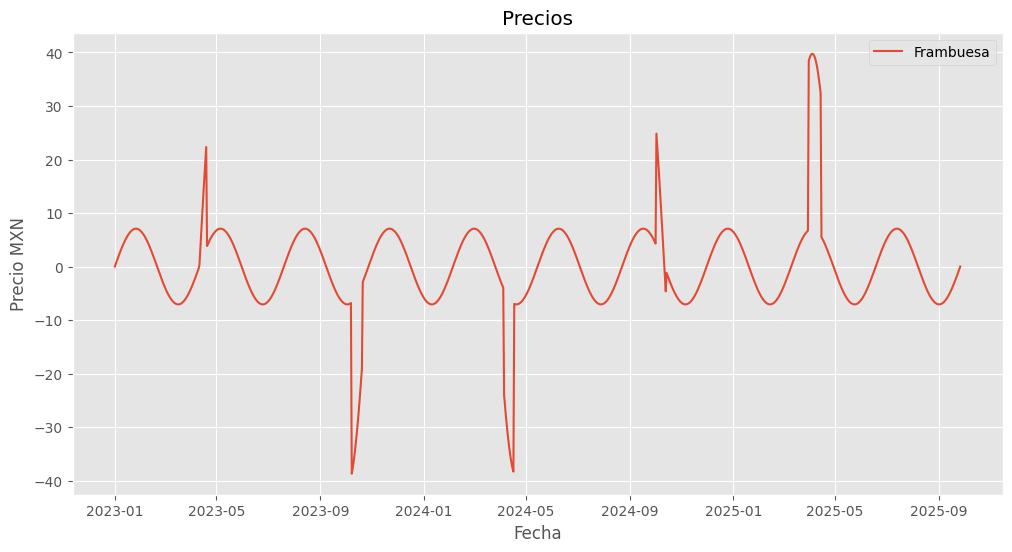

Evolución de precios guardada en 'evolucion_precios.png'
   precio_frambuesa  volumen_frambuesa
0          0.000000          19.738365
1          0.444656          20.736357
2          0.887553          18.733271
3          1.326940          18.733392
4          1.761080          20.800714
Accuracy on train: 0.982
ROC AUC on train: 0.995
Accuracy on valid: 0.98
ROC AUC on valid: 0.992
Precision 1 on train: 0.778
Precision 0 on train: 0.993
Precision 1 on valid: 1.0
Precision 0 on valid: 0.979


In [4]:
params = {
    'precio_frambuesa': 70745,
    'precio_frambuesa_var':2122,
    'volumen_frambuesa':190000,
    'volumen_frambuesa_var':11400,

    'precio_aguacate':20212,
    'precio_aguacate_var':3840,
    'volumen_aguacate':2973000,
    'volumen_aguacate_var':505000,

    'precio_chile':22490,
    'precio_chile_var':787,
    'volumen_chile': 3681000,
    'volumen_chile_var':662580
}


generador = DatosAgricolas(params, n_dias=1000, factor=10000)
df, eventos = generador.generar_datos()
df['y'] = eventos
    
print(np.sum(eventos), len(df))

X = df[['precio_frambuesa', 'volumen_frambuesa']].copy()
Y = df["y"]

plt.figure(figsize=(12, 6))
plt.plot(df['fecha'], df['precio_frambuesa'], label='Frambuesa')
#plt.plot(df['fecha'], df['volumen_aguacate'], label='Aguacate')
#plt.plot(df['fecha'], df['volumen_chile'], label='Chile seco')
plt.title('Precios')
plt.xlabel('Fecha')
plt.ylabel('Precio MXN')
#plt.yscale("log")
plt.legend()
#plt.grid(True)
plt.show()
plt.savefig('evolucion_precios.png')
plt.close()
print("Evolución de precios guardada en 'evolucion_precios.png'")


print(X.head())
df.to_csv('./datos_agricolas_simulados.csv', index=False)


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score

X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=42)


def print_scores(fitted_model):
    res = {
        "Accuracy on train:": accuracy_score(fitted_model.predict(X_train), y_train),
        "ROC AUC on train:": roc_auc_score(
            y_train, fitted_model.predict_proba(X_train)[:, 1]
        ),
        "Accuracy on valid:": accuracy_score(fitted_model.predict(X_valid), y_valid),
        "ROC AUC on valid:": roc_auc_score(
            y_valid, fitted_model.predict_proba(X_valid)[:, 1]
        ),
        "Precision 1 on train:": precision_score(fitted_model.predict(X_train), y_train, pos_label=1),
        "Precision 0 on train:": precision_score(fitted_model.predict(X_train), y_train, pos_label=0),
        "Precision 1 on valid:": precision_score(fitted_model.predict(X_valid), y_valid, pos_label=1),
        "Precision 0 on valid:": precision_score(fitted_model.predict(X_valid), y_valid, pos_label=0),
    }

    for k, v in res.items():
        print(k, round(v, 3))

from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
print_scores(model)


###  2 Análisis TDA completo (homología persistente + Mapper)

Actividades/preguntas:
1. Describa cual es el objetivo principal de esta clase
2. Comentar (describir) las líneas más importantes y escribir documentación adecuada para la clase `AnalisisTDA`
3. En la clase `DatosAgricolas` hay varios parámetros que usted puede ajustar, identifíquelos e interprete ssu efecto en los datos.
4. Describa el outcome que espera de la clase `AnalisisTDA`
5. Discuta cualesquiera otras informaciones en `AnalisisTDA` que puedan ser relevantes.

In [4]:
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.homology import VietorisRipsPersistence
from gtda.metaestimators import CollectionTransformer
from gtda.pipeline import Pipeline
from gtda.time_series import TakensEmbedding, SingleTakensEmbedding
from gtda.time_series import SlidingWindow
from sklearn.decomposition import PCA
import sys


class AnalisisTDA:
    """
    Analisis topologico
    """
    def __init__(self, embedding_type = "TK", only_x = True, univariate = False, option_uni = None):
        self.m_embedder   = embedding_type
        self.m_only_x = only_x
        self.m_univariate = univariate
        self.m_option_uni = option_uni

        
    def homologia_persistente(self, x_datos, y_datos=None, embedding_dimension = 2, embedding_time_delay = 1, window_size = 100,  stride = 4):
        """
        homologia persistente usando Vietoris-Rips. TODO: documentar
        """
        if self.m_embedder == "STK" or (self.m_univariate and self.m_option_uni==1):
            embedder = TakensEmbedding(time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride)            
        elif self.m_embedder == "TK" or (self.m_univariate and self.m_option_uni==2):
            embedder = SingleTakensEmbedding(time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride)
        elif self.m_embedder == "SW":
            embedder = SlidingWindow(size = embedding_dimension, stride=stride)
        else:
            sys.exit("Embedder no disponible!")

        persistence = VietorisRipsPersistence(homology_dimensions=[0, 1, 2], n_jobs=-1)
        scaling = Scaler()
        entropy = PersistenceEntropy(normalize=True, nan_fill_value=-10)

        if self.m_univariate: # one dimensional
            sw = SlidingWindow(size=window_size, stride=stride)
            if self.m_option_uni == 1:   # Option 1: SlidingWindow + TakensEmbedding
                steps_1 = [("sw", sw), ("embedder", embedder), ("persistence", persistence)]
            elif self.m_option_uni == 2: # Option 2: SingleTakensEmbedding + SlidingWindow
                steps_1 = [("embedder", embedder), ("sw", sw), ("persistence", persistence)]
        else: # multidimensional or many signals
            pca = CollectionTransformer(PCA(n_components=3), n_jobs=-1)
            steps_1 = [("embedder", embedder), ("PCA", pca), ("persistence", persistence)]
        
        steps_2 = [("scaling", scaling), ("entropy", entropy)]

        topological_transfomer_1 = Pipeline(steps_1)
        topological_transfomer_2 = Pipeline(steps_2)

        if self.m_option_uni==2:
            pca = PCA(n_components=2)
            steps_v = [("embedder", embedder), ("PCA", pca)]
            plot_cloud = Pipeline(steps_v).fit_transform(x_datos)
            

        if self.m_only_x:
            diagramas = topological_transfomer_1.fit_transform(x_datos)
            trans_features = topological_transfomer_2.fit_transform(diagramas)

        if self.m_option_uni==1:
            return  diagramas[0],trans_features
        elif self.m_option_uni==2:
            return  diagramas[0],trans_features,plot_cloud
    
    
    def mapper_algorithm(self, datos, n_cubiertas=15, overlap=0.3):
        """
        usar el algoritmo mapper. TODO: documentar 
        """
        # configurar algoritmo mapper
        mapper_algoritmo = make_mapper_pipeline(
            projection=Projection(columns=list(range(datos.shape[1]))),
            clusterer=DBSCAN(eps=0.3, min_samples=5),
            cover_n_cubes=n_cubiertas,
            cover_perc_overlap=overlap,
            scaler=MinMaxScaler()
        )
        
        # aplicar mapper
        fig = plot_static_mapper_graph(
            mapper_algoritmo,
            datos,
            color_by_columns_dropdown=True,
            node_color_statistic=np.mean
        )
        
        return fig


In [ ]:
# Probar
class AnalisisTDA:
    """
    Análisis topológico
    """
    def __init__(self, embedding_type="TK", only_x=True, univariate=False, option_uni=None, conversion_method="entropy"):
        """
        Inicialización de la clase AnalisisTDA.

        Parameters:
        - embedding_type: Tipo de embedding ("TK", "STK", "SW").
        - only_x: Si solo se utiliza x_datos.
        - univariate: Si los datos son univariados.
        - option_uni: Opción para datos univariados (1 o 2).
        - conversion_method: Método de conversión de diagramas de persistencia ("entropy", "scaling", "vector").
        """
        self.m_embedder = embedding_type
        self.m_only_x = only_x
        self.m_univariate = univariate
        self.m_option_uni = option_uni
        self.conversion_method = conversion_method

    def homologia_persistente(self, x_datos, y_datos=None, embedding_dimension=2, embedding_time_delay=1, window_size=100, stride=4):
        """
        Homología persistente usando Vietoris-Rips.
        """
        if self.m_embedder == "STK" or (self.m_univariate and self.m_option_uni == 1):
            embedder = TakensEmbedding(time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride)
        elif self.m_embedder == "TK" or (self.m_univariate and self.m_option_uni == 2):
            embedder = SingleTakensEmbedding(time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride)
        elif self.m_embedder == "SW":
            embedder = SlidingWindow(size=embedding_dimension, stride=stride)
        else:
            sys.exit("Embedder no disponible!")

        persistence = VietorisRipsPersistence(homology_dimensions=[0, 1, 2], n_jobs=-1)
        scaling = Scaler()
        entropy = PersistenceEntropy(normalize=True, nan_fill_value=-10)

        if self.m_univariate:  # Datos univariados
            sw = SlidingWindow(size=window_size, stride=stride)
            if self.m_option_uni == 1:  # SlidingWindow + TakensEmbedding
                steps_1 = [("sw", sw), ("embedder", embedder), ("persistence", persistence)]
            elif self.m_option_uni == 2:  # SingleTakensEmbedding + SlidingWindow
                steps_1 = [("embedder", embedder), ("sw", sw), ("persistence", persistence)]
        else:  # Datos multidimensionales
            pca = CollectionTransformer(PCA(n_components=3), n_jobs=-1)
            steps_1 = [("embedder", embedder), ("PCA", pca), ("persistence", persistence)]

        topological_transfomer_1 = Pipeline(steps_1)

        # Configuración del método de conversión
        if self.conversion_method == "entropy":
            steps_2 = [("scaling", scaling), ("entropy", entropy)]
        elif self.conversion_method == "scaling":
            steps_2 = [("scaling", scaling)]
        elif self.conversion_method == "vector":
            vectorization = PersistenceEntropy(normalize=False, nan_fill_value=0)
            steps_2 = [("vectorization", vectorization)]
        else:
            sys.exit("Método de conversión no disponible!")

        topological_transfomer_2 = Pipeline(steps_2)

        if self.m_only_x:
            diagramas = topological_transfomer_1.fit_transform(x_datos)
            trans_features = topological_transfomer_2.fit_transform(diagramas)

        if self.m_option_uni == 1:
            return diagramas[0], trans_features
        elif self.m_option_uni == 2:
            pca = PCA(n_components=2)
            steps_v = [("embedder", embedder), ("PCA", pca)]
            plot_cloud = Pipeline(steps_v).fit_transform(x_datos)
            return diagramas[0], trans_features, plot_cloud

    def mapper_algorithm(self, datos, n_cubiertas=15, overlap=0.3):
        """
        Usar el algoritmo Mapper.
        """
        mapper_algoritmo = make_mapper_pipeline(
            projection=Projection(columns=list(range(datos.shape[1]))),
            clusterer=DBSCAN(eps=0.3, min_samples=5),
            cover_n_cubes=n_cubiertas,
            cover_perc_overlap=overlap,
            scaler=MinMaxScaler()
        )

        fig = plot_static_mapper_graph(
            mapper_algoritmo,
            datos,
            color_by_columns_dropdown=True,
            node_color_statistic=np.mean
        )

        return fig

### 2.1 Probar la clase `AnalisisTDA` con una serie simple univariada

In [ ]:
from gtda.plotting import plot_diagram, plot_point_cloud


mi_tda = AnalisisTDA(embedding_type = "TK", univariate = True, option_uni = 2)
X_univariate = np.array(df["precio_frambuesa"].copy()) # X_train["precio_frambuesa"]

# homologia_persistente(self, datos, embedding_dimension = 2, embedding_time_delay = 1, window_size = 100,  stride = 4)
embedding_dimension = 30
embedding_time_delay = 30
stride = 5
diagrama, features, plot_cloud = mi_tda.homologia_persistente(X_univariate, embedding_dimension = embedding_dimension, embedding_time_delay = embedding_time_delay, window_size = 100,  stride = stride)

# plots
plot_diagram(diagrama)

In [ ]:
plot_point_cloud(plot_cloud)

## Actividades para el 27 de Mayo 2025

#### Objetivo:
Realizar un estudio similar al de ondas gravitacionales, donde se tenian N series de tiempo y se clasificaron las series de tiempo que contenian eventos interesantes o no

#### Pasos:
1. Note que la clase `AnalisisTDA` está adaptada prácticamente para el caso univariado
2. Modificar la clase `DatosAgricolas` para que acepte un parámetro que nos permita generar datos interesantes o no-interesantes
3. Un serie interesante es aquella que contiene eventos con cambios de fase
4. Hay varias opciones de conversión de los diagramas de persistencia a variables manejables. Modifique `AnalisisTDA` para que sea flexible a dichas opciones
5. Explique por que es necesario hacer esta distinción entre una serie univariada y muchas series quizá multivariadas.
6. Ya con las clases `AnalisisTDA` y `DatosAgricolas` cree N series de tiempo con y sin datos interesantes y clasifiquélas